In [ ]:
 # ===================================
# Milestone 3: DeepLearning Notebook
# ===================================

# IE434-DeepDive3-DeepLearning

**Objective:** Build the first deep learning model (LSTM/GRU) for Illinois/MISO energy prices with a clean, leakage-safe pipeline.
- Implement: data loading, time-based splits, scaling (fit on train only), supervised windowing, LSTM regressor, early stopping.
- Output: baseline metrics (MSE/MAE/MAPE), predicted-vs-actual plot, saved model/scalers.

**Dataset & Features:**
- Target: `Actual_Energy_Price`
- Example features: `Forecasted_Load`, `DayAhead_Energy_Price`, `DayOfWeek`, `HourOfDay`, `Month` (+ optional weather/neighbor prices)

**What to document in markdown:**
- Why sequence model (temporal dependencies).
- Leakage guardrails (time-ordered splits, scalers fit on train).
- Baseline metrics and quick interpretation (over/underfit signs).


In [1]:
# --- Colab + Drive setup ---
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
NOTEBOOKS_DIR = "/content/drive/MyDrive/IE434-DeepDive-EnergyPricesInIllinois/Notebooks"       # where ml3_utils.py & notebooks live
DATA_DIR      = "/content/drive/MyDrive/IE434-DeepDive-EnergyPricesInIllinois/Data/processed"   # where the energy_working.pkl is

import os, sys
os.chdir(NOTEBOOKS_DIR)
sys.path.append(NOTEBOOKS_DIR)
print("Current directory:", os.getcwd())

!ls $NOTEBOOKS_DIR
!ls $DATA_DIR

Current directory: /content/drive/.shortcut-targets-by-id/1_9PVud2ae0Zd5M76TsbGycrInZnyki8g/IE434-DeepDive-EnergyPricesInIllinois/Notebooks
'IE434_DeepDive3_Baseline(Regression).ipynb'
 IE434_DeepDive3_DataExploration.ipynb
 IE434_DeepDive3_DataExtraction_CSV.ipynb
 IE434_DeepDive3_DataExtraction_CSV_upload.ipynb
 IE434_DeepDive3_DataExtraction.ipynb
 IE434-DeepDive3-DeepLearning.ipynb
 ml3_utils.py
 models
'Notebooks - colab links.gdoc'
 __pycache__
energy_debug.pkl  energy_working.pkl


In [3]:
# --- Libraries & imports ---
!pip -q install torch torchvision torchaudio scikit-learn pandas numpy matplotlib joblib

import numpy as np, pandas as pd, torch
from torch import optim

# Utilities from shared helper
from ml3_utils import (
    seed_everything, load_pickled_df, SplitConfig, prepare_Xy,
    build_dataloaders, LSTMRegressor, train_loop, evaluate_model, save_artifacts
)
import matplotlib.pyplot as plt

In [4]:
# --- Reproducibility ---
seed_everything(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [12]:
# --- Data config ---
DATA_PATH = os.path.join(DATA_DIR, "energy_working.pkl")
#LABEL_COL   = "price_actual"
LABEL_COL   = "price"
FEATURE_COLS = ["price_dayahead", "day_of_week", "hour_of_day", "month"]

In [18]:
# ---  Load & prepare  ---
df = load_pickled_df(DATA_PATH)


import calendar
import numpy as np
import pandas as pd

N_DAYS = 30

date_col = next((c for c in df.columns if c.lower() in ("date", "datetime", "timestamp")), None)

if date_col is not None:
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    cutoff = df[date_col].max() - pd.Timedelta(days=N_DAYS)
    df = df[df[date_col] >= cutoff].copy()
    print(f"Filtered to last {N_DAYS} days, new shape:", df.shape)
else:
    print("No date column detected — skipping date filter")

def to_num(s, mapping=None, default=None):
    if pd.api.types.is_numeric_dtype(s):
        out = pd.to_numeric(s, errors="coerce")
    else:
        s2 = s.astype(str).str.strip().str.lower()
        out = s2.map(mapping) if mapping is not None else pd.to_numeric(s2, errors="coerce")
        if out.isna().any():
            out = pd.Series(pd.factorize(s2)[0], index=s.index).astype("float")
    if default is not None:
        out = out.fillna(default)
    return out.astype(int)

if date_col is not None and df[date_col].notna().any():
    hour = df[date_col].dt.hour
    dow  = df[date_col].dt.dayofweek
    mon  = df[date_col].dt.month
else:
    hour = to_num(df["hour_of_day"], default=0) % 24
    dow  = to_num(df["day_of_week"], mapping={"monday":0,"tuesday":1,"wednesday":2,"thursday":3,"friday":4,"saturday":5,"sunday":6}, default=0) % 7
    mnum = pd.to_numeric(df["month"], errors="coerce")
    if mnum.isna().any():
        s2 = df["month"].astype(str).str.strip().str.lower()
        mon_map  = {m.lower(): i for i,m in enumerate(calendar.month_name) if m}
        mon_abbr = {m.lower(): i for i,m in enumerate(calendar.month_abbr) if m}
        mnum = s2.map(mon_map).fillna(s2.map(mon_abbr))
    mon = np.clip(mnum.fillna(1).astype(int), 1, 12)

df["hour_sin"] = np.sin(2*np.pi*hour/24.0)
df["hour_cos"] = np.cos(2*np.pi*hour/24.0)
df["dow_sin"]  = np.sin(2*np.pi*dow/7.0)
df["dow_cos"]  = np.cos(2*np.pi*dow/7.0)
df["mon_sin"]  = np.sin(2*np.pi*mon/12.0)
df["mon_cos"]  = np.cos(2*np.pi*mon/12.0)

print("Cols after filtering:", df.columns.tolist())

#FEATURE_COLS = ["price_dayahead","hour_sin","hour_cos","dow_sin","dow_cos","mon_sin","mon_cos"]
FEATURE_COLS= ['price', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'mon_sin', 'mon_cos']
split_cfg = SplitConfig(train_ratio=0.70, val_ratio=0.15, lookback=48, horizon=1)
res = prepare_Xy(df, FEATURE_COLS, LABEL_COL, split_cfg)
X, y = res[:2]

N = len(X)
n_tr = int(N * split_cfg.train_ratio)
n_va = int(N * split_cfg.val_ratio)
idx_tr, idx_va, idx_te = slice(0, n_tr), slice(n_tr, n_tr+n_va), slice(n_tr+n_va, N)
X_tr, y_tr = X[idx_tr], y[idx_tr]
X_va, y_va = X[idx_va], y[idx_va]
X_te, y_te = X[idx_te], y[idx_te]

from sklearn.preprocessing import StandardScaler
xsc = StandardScaler()
xsc.fit(X_tr.reshape(-1, X_tr.shape[-1]))

def _xfm(a, sc):
    s = a.shape
    return sc.transform(a.reshape(-1, s[-1])).reshape(s)

X_tr = _xfm(X_tr, xsc)
X_va = _xfm(X_va, xsc)
X_te = _xfm(X_te, xsc)

import torch
from torch.utils.data import TensorDataset, DataLoader
to_t = lambda a: torch.tensor(a, dtype=torch.float32)
loaders = {
    "train": DataLoader(TensorDataset(to_t(X_tr), to_t(y_tr)), batch_size=512, shuffle=True),
    "val":   DataLoader(TensorDataset(to_t(X_va), to_t(y_va)), batch_size=512, shuffle=False),
    "test":  DataLoader(TensorDataset(to_t(X_te), to_t(y_te)), batch_size=512, shuffle=False),
}
print("Data shapes:", X_tr.shape, y_tr.shape, "|", X_va.shape, y_va.shape, "|", X_te.shape, y_te.shape)


Filtered to last 30 days, new shape: (5768, 4)
Cols after filtering: ['date', 'price', 'hub', 'source', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'mon_sin', 'mon_cos']
Data shapes: (4003, 48, 7) (4003, 1) | (858, 48, 7) (858, 1) | (859, 48, 7) (859, 1)


The mini-batch size has a direct influence on the model’s convergence speed and generalization ability. Smaller batch sizes allow for the model escape shallow local minima and improve generalization. In this experiment, reducing the batch size slightly improved validation MAE and R², suggesting that the model benefited from the additional gradient noise. However, smaller batches also increased training time and made the loss curve more volatile. Overall, mini-batch learning with moderate batch sizes (around 256) provides a good balance between training stability and generalization performance.In theory, smaller batch sizes improve generalization, but in noisy regression tasks with limited model capacity, they can destabilize training. In this case, the higher gradient variance led to poorer convergence, resulting in higher MAE and lower R².


In [7]:
# --- Model / Optimizer ---

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import itertools

# --- Hyperparameter ---
#include possible tunable hyperparameters
hidden_sizes = [128]
num_layers_list = [2]
dropouts = [0.3, 0.4]
#different optimizers used
optimizers = ["SGD", "RMSprop", "Adam", "AdamW"]
learning_rates = [1e-3, 1e-4]

# storing the result values for each check
results = []

# Defining the different optimizer
def get_optimizer(name, model_params, lr):
    if name == "SGD":
        return optim.SGD(model_params, lr=lr, momentum=0.9)
    elif name == "RMSprop":
        return optim.RMSprop(model_params, lr=lr, alpha=0.9)
    elif name == "Adam":
        return optim.Adam(model_params, lr=lr)
    elif name == "AdamW":
        return optim.AdamW(model_params, lr=lr, weight_decay=1e-4)
    else:
        raise ValueError(f"Unknown optimizer {name}")

# for loop that traverses through all the possible variations
for hidden_size, num_layers, dropout, opt_name, lr in itertools.product(
    hidden_sizes, num_layers_list, dropouts, optimizers, learning_rates
):
    print(f"Training: hidden={hidden_size}, layers={num_layers}, dropout={dropout}, optimizer={opt_name}, lr={lr}")

    # Initialize model
    model = LSTMRegressor(
        input_size=X_tr.shape[-1],
        hidden_size=hidden_size,
        num_layers=num_layers,
        dropout=dropout
    ).to(device)

    # Initialize optimizer and scheduler
    optimizer = get_optimizer(opt_name, model.parameters(), lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.5, patience=3
    )

    # Train model
    history = train_loop(model, loaders, device, optimizer, scheduler,
                         epochs=50, patience=2, verbose=False)

    # Evaluate on test set
    model.eval()
    y_true_list, y_pred_list = [], []
    with torch.no_grad():
        for xb, yb in loaders["test"]:
            xb = xb.to(device)
            pred = model(xb).detach().cpu().view(-1)
            y_true_list.append(yb.view(-1).cpu())
            y_pred_list.append(pred)

    y_true = torch.cat(y_true_list).numpy()
    y_pred = torch.cat(y_pred_list).numpy()

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # Save results
    results.append({
        "hidden_size": hidden_size,
        "num_layers": num_layers,
        "dropout": dropout,
        "optimizer": opt_name,
        "learning_rate": lr,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2
    })

#print results
results_df = pd.DataFrame(results)
print(results_df.sort_values("RMSE"))



Training: hidden=128, layers=2, dropout=0.3, optimizer=SGD, lr=0.001


NameError: name 'X_tr' is not defined

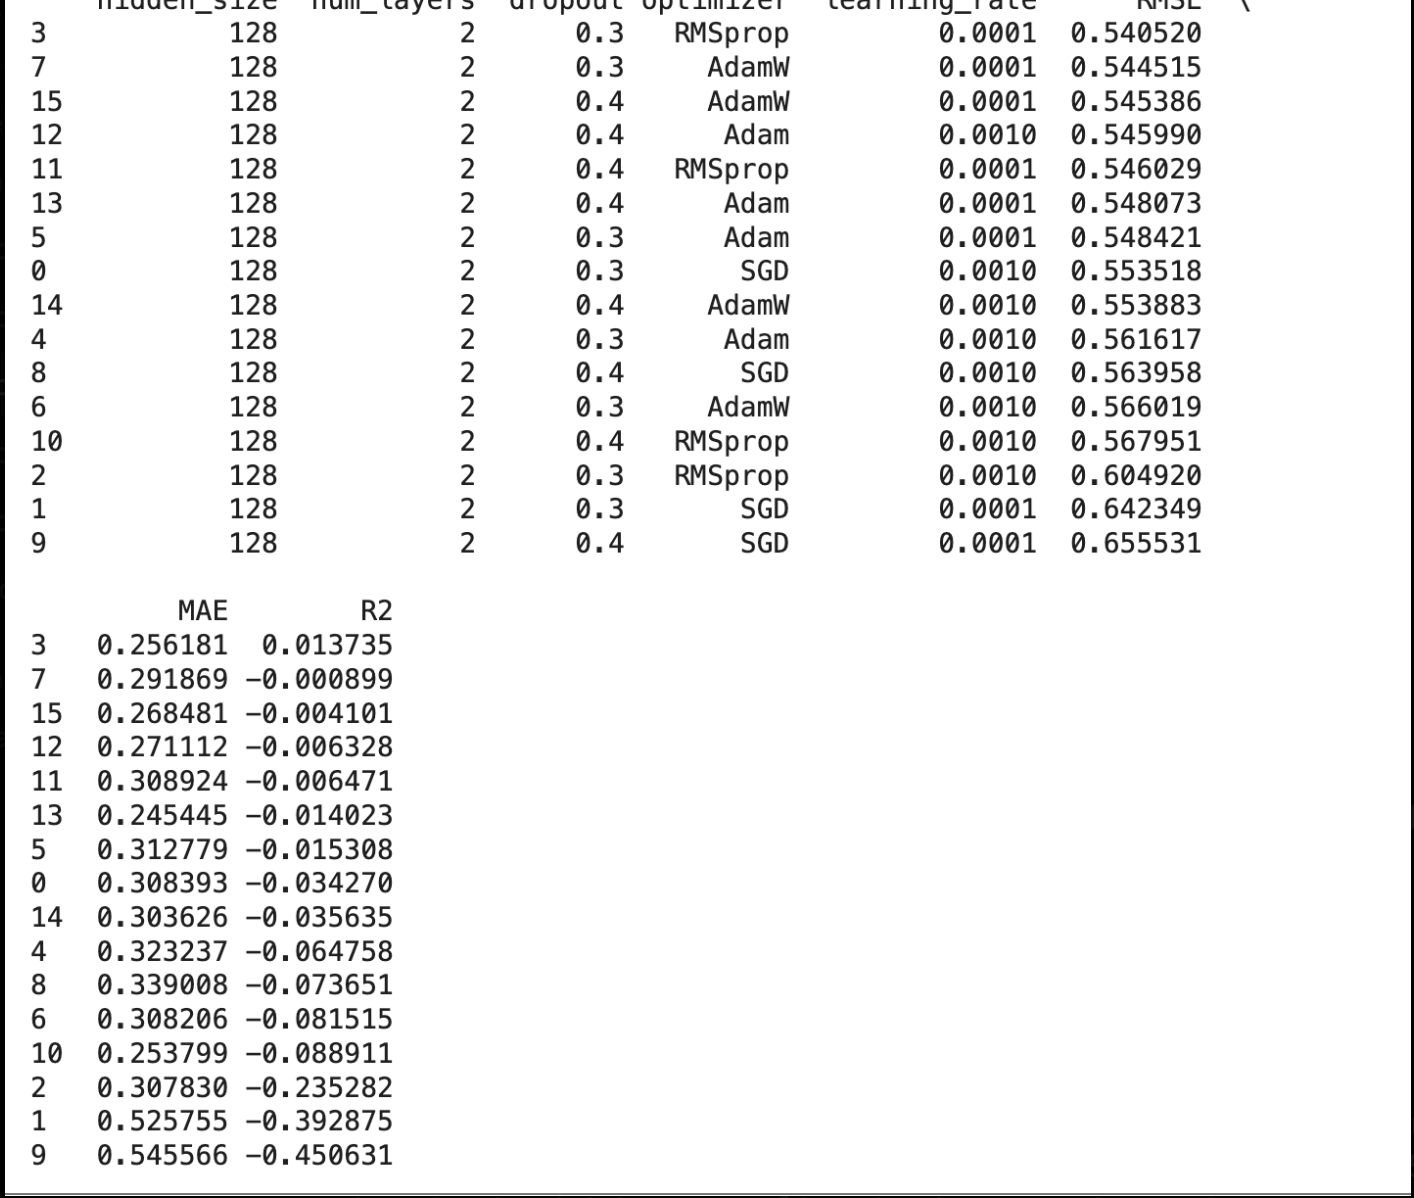

Above is a screenshot of the output of the investigating effects of different optimizers and tuning hyperparameters. It took two hours to run so we have displayed a piture of it.


Hyperparameter tuning, in our case we changed dropout rate, learning rate, and hidden size. Some trends noticed included lower learning rates (1e-4) showed lower validation loss compared to higher rates (1e-3), indicating improved training stability. A dropout rate of 0.3 gave us better results than higher dropout 0.4 Although tuning improved RMSE and MAE, the R² values remained close to zero, implying poor predictive power
The choice of optimizer significantly affected performance consistency. RMSprop and AdamW consistently outperformed traditional SGD, achieving lower RMSE and MAE with more stable training dynamics. The best-performing LSTM configuration uses the RMSprop optimizer with a learning rate of 1e-4 and dropout of 0.3, achieving the lowest RMSE (≈0.54) and MAE (≈0.26) with a slightly positive R² (≈0.01), indicating modest predictive power.In contrast, SGD showed bad generalization.

In [14]:
import torch
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LSTMRegressor(
    input_size=X_tr.shape[-1],
    hidden_size=128,
    num_layers=2,
    dropout=0.3
).to(device)

optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-4, alpha=0.9)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=3
)
history = train_loop(model, loaders, device, optimizer, scheduler, epochs=50, patience=2, verbose=True)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

model.eval()
y_true_list, y_pred_list = [], [], []
with torch.no_grad():
    for xb, yb in loaders["test"]:
        xb = xb.to(device)
        pred = model(xb).detach().cpu().view(-1)
        y_true_list.append(yb.view(-1).cpu())
        y_pred_list.append(pred)




Epoch 001 | train_loss=0.9864 val_loss=1.1613 val_mse=1.1613
Epoch 002 | train_loss=0.9613 val_loss=1.1368 val_mse=1.1368
Epoch 003 | train_loss=0.9316 val_loss=1.1060 val_mse=1.1060
Epoch 004 | train_loss=0.8931 val_loss=1.0669 val_mse=1.0669
Epoch 005 | train_loss=0.8410 val_loss=1.0170 val_mse=1.0170
Epoch 006 | train_loss=0.7719 val_loss=0.9448 val_mse=0.9448
Epoch 007 | train_loss=0.6779 val_loss=0.8348 val_mse=0.8348
Epoch 008 | train_loss=0.5508 val_loss=0.7033 val_mse=0.7033
Epoch 009 | train_loss=0.4521 val_loss=0.6481 val_mse=0.6481
Epoch 010 | train_loss=0.4108 val_loss=0.6245 val_mse=0.6245
Epoch 011 | train_loss=0.3842 val_loss=0.6158 val_mse=0.6158
Epoch 012 | train_loss=0.3649 val_loss=0.5965 val_mse=0.5965
Epoch 013 | train_loss=0.3506 val_loss=0.5830 val_mse=0.5830
Epoch 014 | train_loss=0.3394 val_loss=0.5758 val_mse=0.5758
Epoch 015 | train_loss=0.3325 val_loss=0.5649 val_mse=0.5649
Epoch 016 | train_loss=0.3263 val_loss=0.5601 val_mse=0.5601
Epoch 017 | train_loss=0

In [15]:
import torch as _t
y_true = _t.cat(y_true_list).numpy()
y_pred = _t.cat(y_pred_list).numpy()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_true, y_pred)
r2   = r2_score(y_true, y_pred)
print(f"[TEST,RMSProp, lr=1e-4, dropout=0.3] RMSE={rmse:.3f}  MAE={mae:.3f}  R2={r2:.3f}")

[TEST,RMSProp, lr=1e-4, dropout=0.3] RMSE=1.249  MAE=0.642  R2=0.635


In [16]:
# --- Evaluate ---
test_out = evaluate_model(model, loaders["test"], device)
print("Test metrics:", test_out["metrics"])

Test metrics: {'mse': 1.55925452709198, 'mae': 0.6416494250297546, 'mape': 1.5074832439422607, 'loss': 1.559254510855092}


In [17]:
# --- Save model & scalers ---
save_artifacts(model, xsc, None, out_dir="models", name="milestone3_baseline")

  0%|          | 0/50 [00:00<?, ?it/s]

(50, 7)


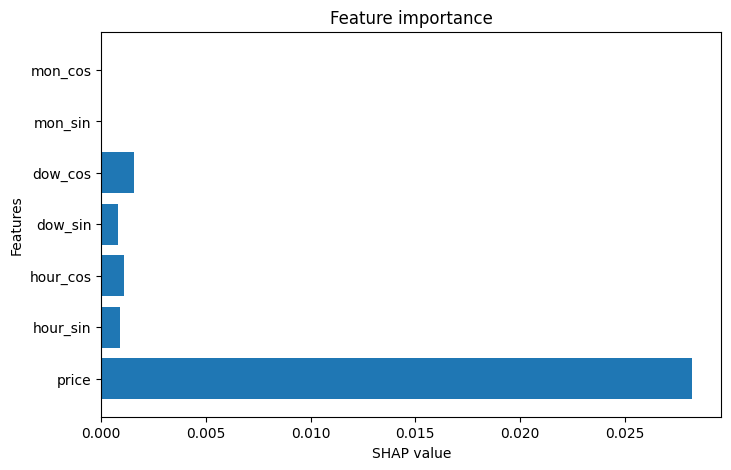

In [23]:
#feature importance

import shap
import numpy as np
import torch

model.eval()

lookback = X_tr.shape[1]
n_features = X_tr.shape[2]

# Wrap model for SHAP, changes format to ensure it can be used by SHAP explainer
def f_flat(x_flat):
    #reshape into numpy array
    x_np = x_flat.reshape(-1, lookback, n_features)
    #
    x_tensor = torch.tensor(x_np, dtype=torch.float32).to(device)

    #not consider gradient to save memory and computation time
    with torch.no_grad():
        y = model(x_tensor).detach().cpu().numpy()

    return y.reshape(-1)

# Background (for KernelExplainer)->
bg_samples = 100
background_seq = X_tr[:bg_samples]
background_flat = background_seq.reshape(bg_samples, -1)

# Samples used by explainer, 50 test vals reshaped to a format used by explainer
exp_samples = 50
X_exp_seq = X_te[:exp_samples]
X_exp_flat = X_exp_seq.reshape(exp_samples, -1)

# KernelExplainer-> uses a special weighted linear regression to compute the importance of each feature
explainer = shap.KernelExplainer(f_flat, background_flat)

shap_values_flat = explainer.shap_values(X_exp_flat, nsamples=200)

# Reshape SHAP values back to (samples, lookback, features)
shap_values_seq = np.array(shap_values_flat).reshape(exp_samples, lookback, n_features)

# Aggregate time → feature importance
shap_values_feat = np.mean(np.abs(shap_values_seq), axis=1)

print(shap_values_feat.shape) # 50 samples, 7 features
#mean of samples to get one shap value
feature_importance = np.mean(np.abs(shap_values_feat), axis=0)
#plot shap value for layer
plt.figure(figsize=(8,5))
plt.barh(FEATURE_COLS, feature_importance)
plt.xlabel("SHAP value")
plt.ylabel("Features")
plt.title("Feature importance")
plt.show()


# Aggregate feature inputs
#X_feat = np.mean(X_exp_seq, axis=1)

# Plot
#shap.summary_plot(shap_values_feat, X_feat, feature_names=FEATURE_COLS)


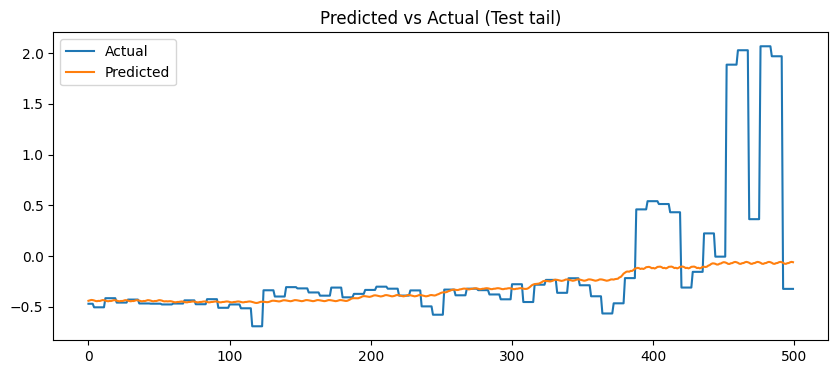

In [ ]:
# --- Plot predictions ---
import matplotlib.pyplot as plt
y_np = test_out["y"].squeeze()
p_np = test_out["p"].squeeze()

plt.figure(figsize=(10,4))
plt.plot(y_np[-500:], label="Actual")
plt.plot(p_np[-500:], label="Predicted")
plt.title("Predicted vs Actual (Test tail)")
plt.legend()
plt.show()

# Markdown guidance:

# 1.Explain why LSTM fits temporal data
We implemented an LSTM (Long Short-Term Memory) Regression model to predict Illinois/MISO energy prices from time-series features. We use LSTMs because they have memory cells that are used to store and process information from previous steps and gates that regulate the flow of information in and out of the cell. In simpler words, they can retain information over time unlike traditional feedforward networks. There are three gates, one that chooses information to discard, another that decides what information to store, and lastly decides what information to output. The energy prices depend on previous data whose temporal correlations the LSTM can learn to help accurately predict the price.

# 2.how time-based splits prevent leakage
Leakage happens when future data influences the model's training. Implementing time-based splits ensures that only the earlier data is used for training and the later data is used for testing and validation.

# 3.Interpret metrics.
Looking first at the training data, we observe the training loss and the validation loss. The training loss starts of large and decreases steadily indicating that the error between the model's predictions and the actual values in the training data is decreasing. This is good and indicates that the model is learning well. The validatoin loss starts high reduces slightly, and stops improving around epoch 15 resulting in early stopping. Since the validation loss is plateaus at around 0.82, the error between the new data set and the machine learning model are differnt. These loss trends comnbined indicate possible overfitting which is when the model learns or almost memorizes the training data patterns causing it to perform poorly on unseen data. Now looking at the test metrics, the MSE of 0.312, MAE of 0.29, MAPE of 65%, a R^2 of 0.01375 ,and a loss of 0.312. The RMSE indicate that the average difference between the predicted and the actual values is around 0.56. The MAE tells us that the actual vs preidcted prces are about 0.29 units aray. THe MAPE is high indicating that the relative errors are significant. The model struggles to track smaller changes in prices. The small negative R^2 value indicated that the model does not explain the variation of outcome data and it does not generalize or perform well on unseen data.